**MLP**

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import random_split

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 20
batch_size = 128
learning_rate = 0.001

# CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(32 * 32 * 3, 512)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.layer3(x)
        return x

# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Testing
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct / total
    return train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, all_preds, all_labels

# Plot learning curves
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('MLP Learning Curves - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('MLP Learning Curves - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    plt.savefig('mlp_learning_curves.png')
    plt.close()

# Plot confusion matrix
def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix - MLP')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.savefig('confusion_matrix_mlp.png')
    plt.close()

# Main execution

# Train and evaluate MLP
mlp = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
print("Training MLP...")
mlp_metrics = train_and_evaluate(mlp, train_loader, val_loader, criterion, optimizer, num_epochs)
print(f'\nMLP Test Accuracy: {mlp_metrics[4]:.2f}%')

# Summary
print("\nMLP Results:")
print(f"Final Train Accuracy: {mlp_metrics[2][-1]:.2f}%")
print(f"Final Validation Accuracy: {mlp_metrics[3][-1]:.2f}%")
print(f"Final Test Accuracy: {mlp_metrics[4]:.2f}%")



Training MLP...
Epoch [1/20], Train Loss: 1.6881, Train Acc: 39.77%, Val Loss: 1.5330, Val Acc: 45.65%
Epoch [2/20], Train Loss: 1.4944, Train Acc: 47.12%, Val Loss: 1.4877, Val Acc: 48.18%
Epoch [3/20], Train Loss: 1.4102, Train Acc: 50.13%, Val Loss: 1.4021, Val Acc: 50.45%
Epoch [4/20], Train Loss: 1.3489, Train Acc: 52.01%, Val Loss: 1.3711, Val Acc: 51.39%
Epoch [5/20], Train Loss: 1.2999, Train Acc: 53.71%, Val Loss: 1.3686, Val Acc: 51.89%
Epoch [6/20], Train Loss: 1.2644, Train Acc: 54.86%, Val Loss: 1.3219, Val Acc: 53.48%
Epoch [7/20], Train Loss: 1.2188, Train Acc: 56.69%, Val Loss: 1.3432, Val Acc: 53.22%
Epoch [8/20], Train Loss: 1.1907, Train Acc: 57.45%, Val Loss: 1.3282, Val Acc: 53.65%
Epoch [9/20], Train Loss: 1.1620, Train Acc: 58.36%, Val Loss: 1.3220, Val Acc: 53.60%
Epoch [10/20], Train Loss: 1.1275, Train Acc: 59.68%, Val Loss: 1.3045, Val Acc: 55.36%
Epoch [11/20], Train Loss: 1.1053, Train Acc: 60.24%, Val Loss: 1.3135, Val Acc: 54.78%
Epoch [12/20], Train Loss

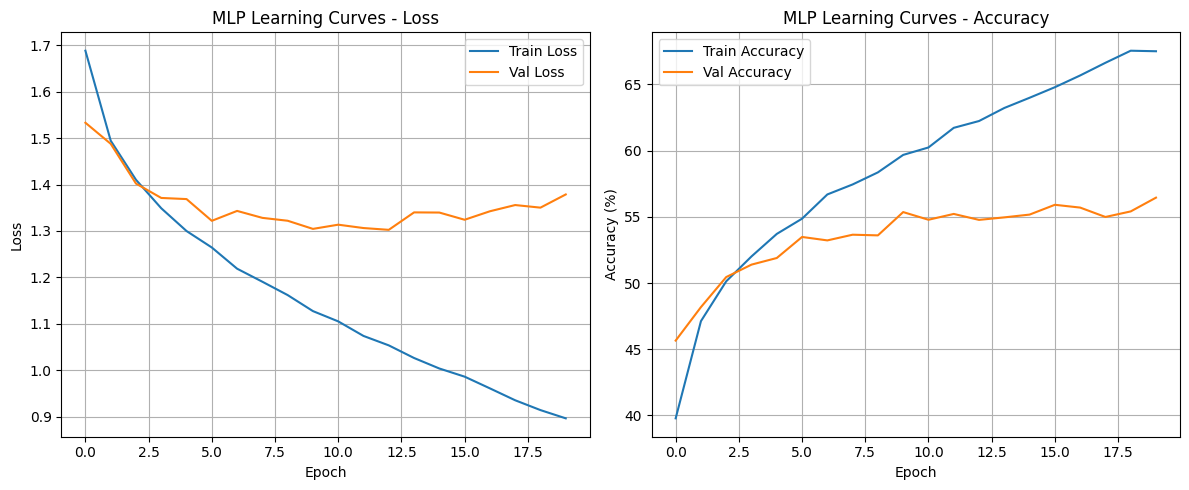

In [6]:
# Plot results
plot_learning_curves(mlp_metrics[0], mlp_metrics[1], mlp_metrics[2], mlp_metrics[3])

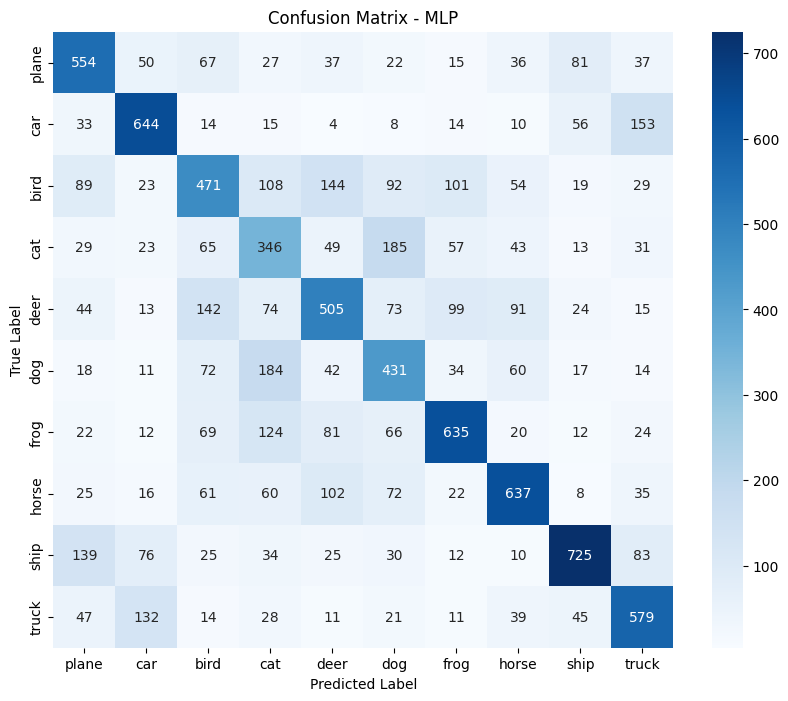

In [7]:
# Plot results
plot_confusion_matrix(mlp_metrics[5], mlp_metrics[6])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**CNN**

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import random_split

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 20
batch_size = 128
learning_rate = 0.001

# CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Testing
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct / total
    return train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, all_preds, all_labels

# Plot learning curves
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('CNN Learning Curves - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('CNN Learning Curves - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig('cnn_learning_curves.png')
    plt.close()

# Plot confusion matrix
def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix - CNN')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.savefig('confusion_matrix_cnn.png')
    plt.close()

# Main execution

# Train and evaluate CNN
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
print("Training CNN...")
cnn_metrics = train_and_evaluate(cnn, train_loader, val_loader, criterion, optimizer, num_epochs)
print(f'\nCNN Test Accuracy: {cnn_metrics[4]:.2f}%')

# Summary
print("\nCNN Results:")
print(f"Final Train Accuracy: {cnn_metrics[2][-1]:.2f}%")
print(f"Final Validation Accuracy: {cnn_metrics[3][-1]:.2f}%")
print(f"Final Test Accuracy: {cnn_metrics[4]:.2f}%")



Training CNN...
Epoch [1/20], Train Loss: 1.6121, Train Acc: 41.03%, Val Loss: 1.3101, Val Acc: 52.23%
Epoch [2/20], Train Loss: 1.2417, Train Acc: 55.87%, Val Loss: 1.1186, Val Acc: 60.41%
Epoch [3/20], Train Loss: 1.0800, Train Acc: 61.78%, Val Loss: 0.9669, Val Acc: 65.37%
Epoch [4/20], Train Loss: 0.9802, Train Acc: 65.33%, Val Loss: 0.8861, Val Acc: 68.69%
Epoch [5/20], Train Loss: 0.8979, Train Acc: 68.33%, Val Loss: 0.8546, Val Acc: 70.03%
Epoch [6/20], Train Loss: 0.8427, Train Acc: 70.57%, Val Loss: 0.8265, Val Acc: 70.71%
Epoch [7/20], Train Loss: 0.7942, Train Acc: 72.01%, Val Loss: 0.7745, Val Acc: 72.57%
Epoch [8/20], Train Loss: 0.7579, Train Acc: 73.54%, Val Loss: 0.7421, Val Acc: 73.48%
Epoch [9/20], Train Loss: 0.7243, Train Acc: 74.67%, Val Loss: 0.7307, Val Acc: 74.51%
Epoch [10/20], Train Loss: 0.6918, Train Acc: 75.73%, Val Loss: 0.7156, Val Acc: 74.91%
Epoch [11/20], Train Loss: 0.6654, Train Acc: 76.77%, Val Loss: 0.6929, Val Acc: 76.08%
Epoch [12/20], Train Loss

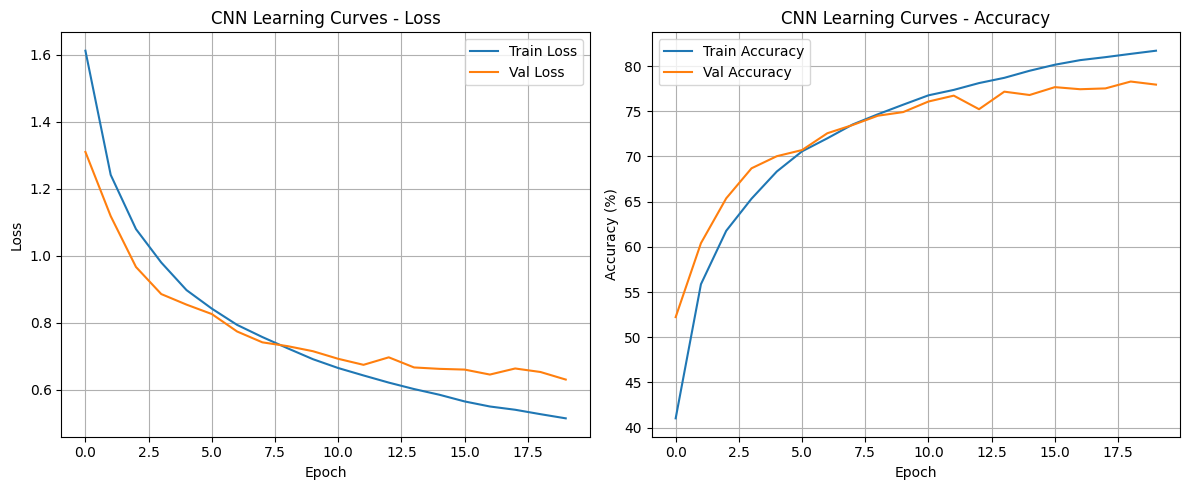

In [10]:
# Plot results
plot_learning_curves(cnn_metrics[0], cnn_metrics[1], cnn_metrics[2], cnn_metrics[3])



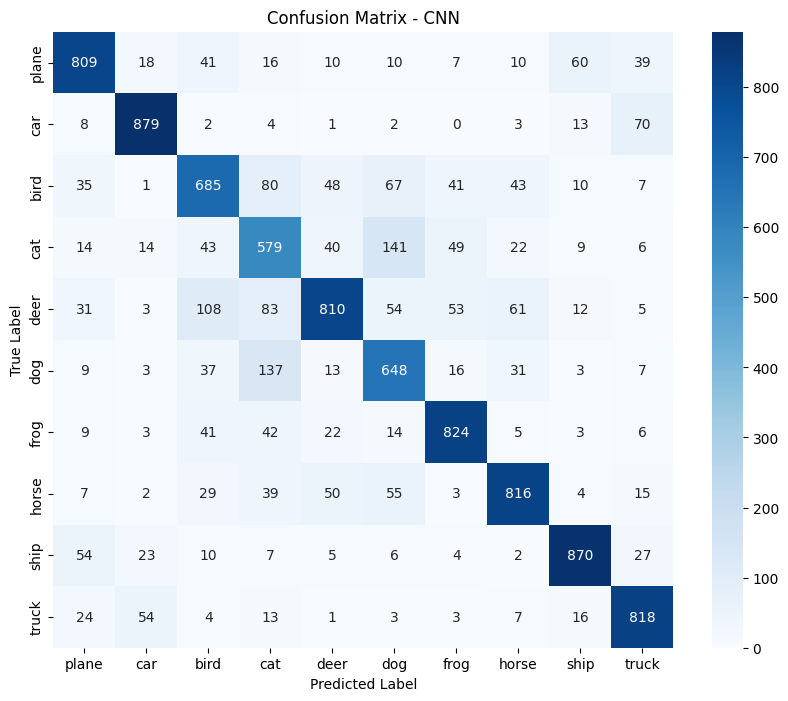

In [11]:
# Plot results
plot_confusion_matrix(cnn_metrics[5], cnn_metrics[6])


**SO SÁNH**

In [9]:
# Comparison and discussion
print("\nModel Comparison:")
print(f"MLP Test Accuracy: {mlp_metrics[4]:.2f}%")
print(f"CNN Test Accuracy: {cnn_metrics[4]:.2f}%")
print("\nDiscussion:")
print("1. CNN outperforms MLP due to its ability to capture spatial hierarchies through convolutional layers, while MLP flattens images, losing spatial information.")
print("2. CNN's weight sharing reduces parameters, making it less prone to overfitting compared to MLP's large fully connected layers.")
print("3. Pooling in CNN provides translation invariance, improving robustness to image variations.")
print("4. Data augmentation (flipping, rotation) benefits CNN more, as it leverages local patterns effectively.")
print("5. Dropout in CNN further improves generalization.")


Model Comparison:
MLP Test Accuracy: 55.27%
CNN Test Accuracy: 77.38%

Discussion:
1. CNN outperforms MLP due to its ability to capture spatial hierarchies through convolutional layers, while MLP flattens images, losing spatial information.
2. CNN's weight sharing reduces parameters, making it less prone to overfitting compared to MLP's large fully connected layers.
3. Pooling in CNN provides translation invariance, improving robustness to image variations.
4. Data augmentation (flipping, rotation) benefits CNN more, as it leverages local patterns effectively.
5. Dropout in CNN further improves generalization.
